<a href="https://colab.research.google.com/github/anushadatar/Olin-Data-Science-SP20/blob/master/02_partyid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Political Alignment Case Study

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

### Introduction

This is the second in a series of notebooks that make up a case study in exploratory data analysis.

In this notebook, we:

1. Look at responses to the variable `p`, which represent political alignment on a 7-point scale from liberal to conservative.

2. Compare the distribution of responses in 1974 and 1990.

3. Plot the mean and standard deviation of responses over time as a way of quantifying changes in political alignment and polarization.

4. Use local regression to plot a smooth line through noisy data.

5. Use cross tabulation to compute the fraction of respondents in each category over time.

6. Plot the results using a custom color palette.

As an exercise, you will look at changes in political party affiliation over the same period.

### Setup

If you are running this notebook in Colab, the following cell downloads the `empiricaldist` library.

If you are running in another environment, you will need to install it yourself.

In [1]:
# If we're running in Colab, set up the environment

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

  Created wheel for empiricaldist: filename=empiricaldist-0.3.4-cp36-none-any.whl size=9201 sha256=89f3878216a34acf74418c3b71452faa841e2b140a6258851a428e388574b692
  Stored in directory: /root/.cache/pip/wheels/ac/73/c9/8f65a5da21549c874a85614bff3413ddc0e441b9b0c73a823b
Successfully built empiricaldist


If everything we need is installed, the following cell should run without error.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf

The following cell defines a function I use to decorate the axes in plots.

In [0]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

### Loading the data

In the previous notebook, we downloaded GSS data, loaded and cleaned it, resampled it to correct for stratified sampling, and then saved the data in an HDF5 file, which is much faster to load.  In this and the following notebooks, we'll download the HDF5 file and load it.

The following cell downloads the file.

In [4]:
# Load the data file

import os

datafile = 'gss_eda.3.hdf5'
if not os.path.exists(datafile):
    !wget https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.3.hdf5


--2020-02-12 04:58:55--  https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/master/gss_eda.3.hdf5
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/AllenDowney/PoliticalAlignmentCaseStudy/master/gss_eda.3.hdf5 [following]
--2020-02-12 04:58:55--  https://raw.githubusercontent.com/AllenDowney/PoliticalAlignmentCaseStudy/master/gss_eda.3.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19281025 (18M) [application/octet-stream]
Saving to: ‘gss_eda.3.hdf5’

gss_eda.3.hdf5      100%[===================>]  18.39M   100MB/s    in 0.2s    

2020-02-12 04:58:56 (100 MB/s) - ‘gss_eda.3.hdf5’ save

This file contains three DataFrames containing resamples of the GSS data.  We'll work with the first resampling, `gss0`, to get started; at the end of this notebook, we'll see the other two as well.

In [67]:
gss = pd.read_hdf(datafile, 'gss0')
gss.shape

(64814, 165)

## Political alignment

The people surveyed as part of the GSS were asked about their "political alignment", which is where they place themselves on a spectrum from liberal to conservative.

The variable `partyid` contains responses to the [following question](https://gssdataexplorer.norc.org/projects/52787/variables/178/vshow):

> We hear a lot of talk these days about liberals and conservatives. 
I'm going to show you a seven-point scale on which the political views that people might hold are arranged from extremely liberal--point 1--to extremely conservative--point 7. Where would you place yourself on this scale?

Here are the valid responses:

```
1	Extremely liberal
2	Liberal
3	Slightly liberal
4	Moderate
5	Slightly conservative
6	Conservative
7	Extremely conservative
```

To see how the responses have changed over time, we'll inspect them at the beginning and end of the observation period.

First I'll select the column.

In [0]:
partyid = gss['partyid']

Then compute a Boolean Series that's `True` for responses from 1974.

In [0]:
year74 = (gss['year'] == 1974)

Now we can select the responses from 1974.

In [0]:
partyid74 = partyid[year74]

As in the previous notebook, we'll use `values` to plot the values in the series and their frequencies.

In [0]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts().sort_index()

Here are the responses from 1974.

In [72]:

values(partyid74)

0.0    273
1.0    394
2.0    173
3.0    130
4.0    102
5.0    203
6.0    112
7.0     68
Name: partyid, dtype: int64

And here are the responses from 2018.

In [73]:
year18 = (gss['year'] == 2018)
partyid18 = partyid[year18]
values(partyid18)

0.0    318
1.0    367
2.0    313
3.0    408
4.0    290
5.0    276
6.0    249
7.0     89
Name: partyid, dtype: int64

## PMFs

To visualize these distributions, we'll use the Probability Mass Function (PMF), which is similar to a histogram.  The difference is that the PMF is "normalized", which means that it shows the percentage of people who gave each response, rather than the number.

I use the `Pmf` class from `empiricaldist` to compute them.

In [0]:
from empiricaldist import Pmf

Here's the distribution from 1974:

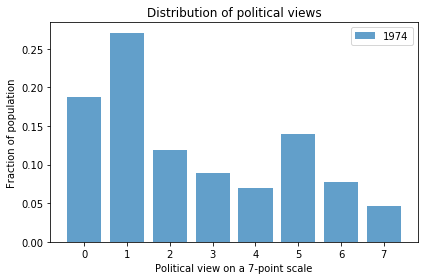

In [75]:
pmf74 = Pmf.from_seq(partyid74)
pmf74.bar(label='1974', color='C0', alpha=0.7)

decorate(xlabel='Political view on a 7-point scale',
         ylabel='Fraction of population',
         title='Distribution of political views')

plt.legend();

Here's the distribution from 1974:

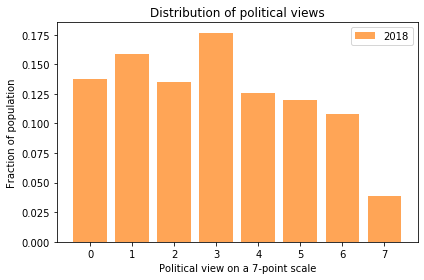

In [76]:
pmf18 = Pmf.from_seq(partyid18)
pmf18.bar(label='2018', color='C1', alpha=0.7)

decorate(xlabel='Political view on a 7-point scale',
         ylabel='Fraction of population',
         title='Distribution of political views')

plt.legend();

In both cases, the most common response is `4`, which is the code for "moderate".  And few respondents describe themselves as "extremely" liberal or conservative.

So maybe we're not so polarized after all.

To make it easier to compare the distributions, I'll plot them side by side.  

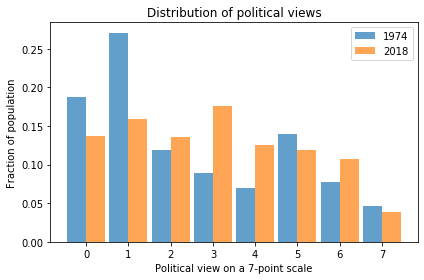

In [77]:
pmf74.bar(label='1974', width=-0.45, align='edge', alpha=0.7)

pmf18.bar(label='2018', width=0.45, align='edge', alpha=0.7)

decorate(xlabel='Political view on a 7-point scale',
         ylabel='Fraction of population',
         title='Distribution of political views')

plt.legend();

Now we can see the changes in the distribution more clearly.  It looks like the number of people at the extremes (1 and 7) has increased, and the fraction of liberal (2) and slightly liberal (3) has decreased.

**Exercise:** To summarize these changes, we can compare the mean and standard deviation of `partyid` in 1974 and 2018.

The mean of the responses measures the balance of people in the population with liberal or conservative leanings.  If the mean increases over time, that might indicate a shift in the population toward conservatism.

The standard deviation measures the dispersion of views in the population; if it increases over time, that might indicate an increase in polarization.

Compute the mean and standard deviation of `partyid74` and `partyid18`.

What do they indicate about changes over this interval?

In [78]:
# Solution goes here
print(partyid74.mean())
partyid74.std()

2.543642520904541


2.1804733276367188

In [79]:
# Solution goes here
print(partyid18.mean())
partyid18.std()

2.975757598876953


2.049697160720825

In [0]:
# Solution goes here
# The standard deviation has decreased a little, suggesting people might have slightly
# less extreme party leanings...

## Time series

At this point we have looked at the endpoints, 1974 and 2018, but we don't know what happened in between.

To see how the distribution changes over time, we can group by year and compute the mean of `partyid` during each year.

First I'll use `groupby` to group the respondents by year.

In [81]:
gss_by_year = gss.groupby('year')
gss_by_year

The result is a `DataFrameGroupBy` value that represents a collection of groups.  We can loop through the groups and display the number of respondents in each:

In [82]:
for year, group in gss_by_year:
    print(year, len(group))

1972 1613
1973 1504
1974 1484
1975 1490
1976 1499
1977 1530
1978 1532
1980 1468
1982 1860
1983 1599
1984 1473
1985 1534
1986 1470
1987 1819
1988 1481
1989 1537
1990 1372
1991 1517
1993 1606
1994 2992
1996 2904
1998 2832
2000 2817
2002 2765
2004 2812
2006 4510
2008 2023
2010 2044
2012 1974
2014 2538
2016 2867
2018 2348


In many ways the `DataFrameGroupBy` behaves like a DataFrame.  We can use the bracket operator to select a column: 

In [83]:
partyid_by_year = gss_by_year['partyid']
partyid_by_year

A column from a `DataFrameGroupBy` is a `SeriesGroupBy`.  If we invoke `mean` on it, the results is a series that contains the mean of `partyid` for each year of the survey.

In [0]:
mean_series = partyid_by_year.mean()

And here's what it looks like.

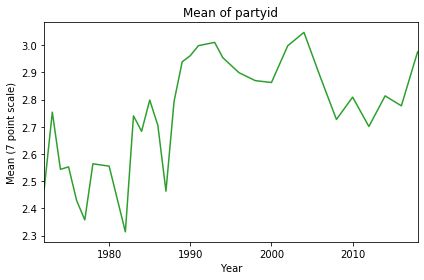

In [85]:
mean_series.plot(color='C2', label='partyid')
decorate(xlabel='Year', 
         ylabel='Mean (7 point scale)',
         title='Mean of partyid')

**Exercise:** The standard deviation quantifies the spread of the distribution, which is one way to measure polarization.

Plot standard deviation of `partyid` for each year of the survey from 1972 to 2018.

Does it show evidence of increasing polarization?

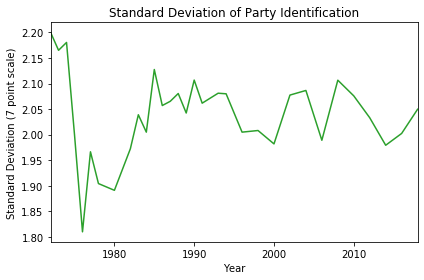

In [86]:
# Solution goes here
std_series = partyid_by_year.std()
std_series.plot(color='C2', label='partyid')
decorate(xlabel='Year', 
         ylabel='Standard Deviation (7 point scale)',
         title='Standard Deviation of Party Identification')
# It does show absolute delta in party identification, but a lot of fluctuation.

### Local regression

In the previous section we plotted mean and standard deviation of `partyid` over time.  Both plots are quite noisy.

We can use [local regression](https://en.wikipedia.org/wiki/Local_regression) to compute a smooth line through these data points.  

The following function takes a Pandas Series and uses and algorithm called LOWESS to compute a smooth line.  LOWESS stands for "locally weighted scatterplot smoothing".

In [0]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index) 

We'll use the following function to plot data points and the smoothed line.

In [0]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.
    
    series: pd.Series
    color: string or tuple
    """
    series.plot(linewidth=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

The following figure shows the mean of `partyid` and a smooth line.

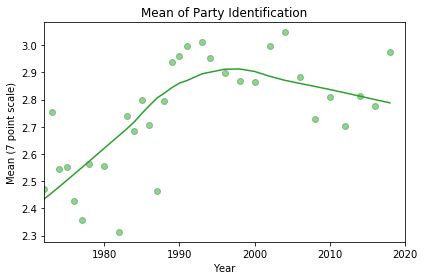

In [89]:
mean_series = gss_by_year['partyid'].mean()
plot_series_lowess(mean_series, 'C2')
decorate(ylabel='Mean (7 point scale)',
         title='Mean of Party Identification',
         xlabel='Year',
         xlim=[1972, 2020])

One reason the PMFs for 1974 and 2018 did not look very different is that the mean seems to have gone up (more conservative) and then down again (more liberal).

Generally, it looks like the U.S. has been trending toward liberal for the last 20 years, or more, at least in the sense of how people describe themselves.

**Exercise:** Use `plot_series_lowess` to plot the standard deviation of `partyid` with a smooth line.

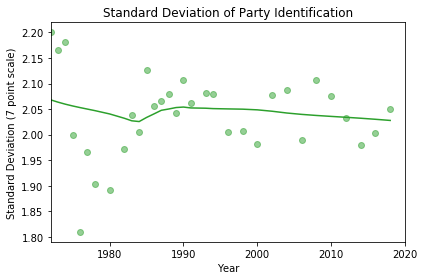

In [90]:
# Solution goes here
std_series = gss_by_year['partyid'].std()
plot_series_lowess(std_series, 'C2')
decorate(ylabel='Standard Deviation (7 point scale)',
         title='Standard Deviation of Party Identification',
         xlabel='Year',
         xlim=[1972, 2020])

## Cross tabulation

In the previous sections, we treated `partyid` as a numerical quantity, so we were able to compute means and standard deviations.

But the responses are really categorical, which means that each value represents a discrete category, like "liberal" or "conservative".  

In this section, we'll treat `partyid` as a categorical variable.  Specifically, we'll compute the number of respondents in each category for each year, and plot changes over time.

Pandas provides a function called `crosstab` that computes a [cross tabulation](https://en.wikipedia.org/wiki/Contingency_table).

It takes two Series as arguments and returns a DataFrame.

In [0]:
year = gss['year']
column = gss['partyid']

xtab = pd.crosstab(year, column)

Here are the first few lines from the result.

In [92]:
xtab.head()

partyid,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
year,,,,,,,,
1972,341,448,147,146,84,250,132,59
1973,226,372,195,140,141,229,101,87
1974,273,394,173,130,102,203,112,68
1975,258,353,186,190,117,258,110,10
1976,205,397,236,241,131,202,81,3


It contains one row for each value of `year` and one column for each value of `partyid`.  Reading the first row, we see that in 1974, 31 people gave response 1, "extremely liberal", 201 people gave response 2, "liberal", and so on.

The number of respondents varies from year to year, so we need to "normalize" the results, which means computing for each year the *fraction* of respondents in each category, rather than the count.

`crosstab` takes an optional argument that normalizes each row.

In [0]:
xtab_norm = pd.crosstab(year, column, normalize='index')

Here's what that looks like for the 7-point scale.

In [94]:
xtab_norm.head()

partyid,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0
year,,,,,,,,
1972,0.212197,0.278780,0.091475,0.090853,0.052271,0.155569,0.082141,0.036714
1973,0.151576,0.249497,0.130785,0.093897,0.094567,0.153588,0.067740,0.058350
1974,0.187629,0.270790,0.118900,0.089347,0.070103,0.139519,0.076976,0.046735
1975,0.174089,0.238192,0.125506,0.128205,0.078947,0.174089,0.074224,0.006748
1976,0.137032,0.265374,0.157754,0.161096,0.087567,0.135027,0.054144,0.002005


To make the results easier to interpret, I'm going to replace the numeric codes 1-7 with strings.  First I'll make a dictionary that maps from numbers to strings:

In [0]:
# recode the 7 point scale with words
d7 = {0: 'Strong democrat',
      1: 'Not str democrat',
      2: 'Ind,near dem',
      3: 'Independent',
      4: 'Ind,near rep',
      5: 'Not str republican',
      6: 'Strong republican',
      7: 'Other party'
}


Then we can use the `replace` function like this:

In [0]:
partyid7 = gss['partyid'].replace(d7)

We can use `values` to confirm that the values in `partyid7` are strings.

In [97]:
values(partyid7)

Ind,near dem           7565
Ind,near rep           5994
Independent            9845
Not str democrat      13311
Not str republican    10156
Other party            1064
Strong democrat        9997
Strong republican      6461
Name: partyid, dtype: int64

If we make the cross tabulation again, we can see that the column names are strings.

In [98]:
xtab_norm = pd.crosstab(year, partyid7, normalize='index')
xtab_norm.head()

partyid,"Ind,near dem","Ind,near rep",Independent,Not str democrat,Not str republican,Other party,Strong democrat,Strong republican
year,,,,,,,,
1972,0.091475,0.052271,0.090853,0.278780,0.155569,0.036714,0.212197,0.082141
1973,0.130785,0.094567,0.093897,0.249497,0.153588,0.058350,0.151576,0.067740
1974,0.118900,0.070103,0.089347,0.270790,0.139519,0.046735,0.187629,0.076976
1975,0.125506,0.078947,0.128205,0.238192,0.174089,0.006748,0.174089,0.074224
1976,0.157754,0.087567,0.161096,0.265374,0.135027,0.002005,0.137032,0.054144


We are almost ready to plot the results, but first we need some colors.

## Color palettes

Seaborn provides a variety of color palettes,  [which you can read about here](https://seaborn.pydata.org/tutorial/color_palettes.html).

To represent political views, I'll use a diverging palette from blue to red.

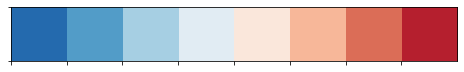

In [118]:
palette = sns.color_palette('RdBu_r', 8)
sns.palplot(palette)

The middle color is white, which won't work when we plot it, so I will replace it with a purple color from another palette.

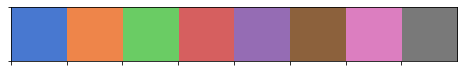

In [119]:
muted = sns.color_palette('muted', 8)
purple = muted[4]
sns.palplot(muted)

Here's the modified diverging palette  with purple in the middle.

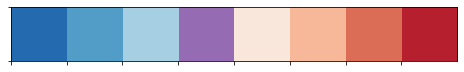

In [120]:
palette[3] = purple
sns.palplot(palette)

Now I'll make a "color map", which is a dictionary that maps from the responses to the corresponding colors.

In [0]:
columns = ['Strong democrat',
         'Not str democrat',
         'Ind,near dem',
         'Independent',
         'Ind,near rep',
         'Not str republican',
         'Strong republican',
         'Other party']

In [122]:

color_map = dict(zip(columns, palette))

for key, value in color_map.items():
    print(key, value)

Strong democrat (0.14248366013071898, 0.41730103806228375, 0.6833525567089581)
Not str democrat (0.3234909650134563, 0.6149173394848135, 0.7854671280276816)
Ind,near dem (0.6549019607843136, 0.8143790849673203, 0.8941176470588235)
Independent (0.5843137254901961, 0.4235294117647059, 0.7058823529411765)
Ind,near rep (0.9820069204152249, 0.9061899269511726, 0.8615916955017302)
Not str republican (0.9686274509803923, 0.7176470588235296, 0.6000000000000003)
Strong republican (0.8622837370242215, 0.429527104959631, 0.3427143406382161)
Other party (0.7118800461361015, 0.12179930795847749, 0.18169934640522878)


## Plotting

To plot the results, I use the following function, which takes a `DataFrame` and plots each column using `plot_series_lowess`.

In [0]:
def plot_columns_lowess(table, columns, colors):
    """Plot the columns in a DataFrame.
    
    table: DataFrame with a cross tabulation
    columns: list of column names, in the desired order
    colors: mapping from column names to colors
    """
    for col in columns:
        series = table[col]
        plot_series_lowess(series, colors[col])

The following function sets the position of the figure legend.

In [0]:
def anchor_legend(x, y):
    """Place the upper left corner of the legend box.
    
    x: x coordinate
    y: y coordinate
    """
    plt.legend(bbox_to_anchor=(x, y), loc='upper left', ncol=1)

Here are the 7 categories plotted as a function of time.

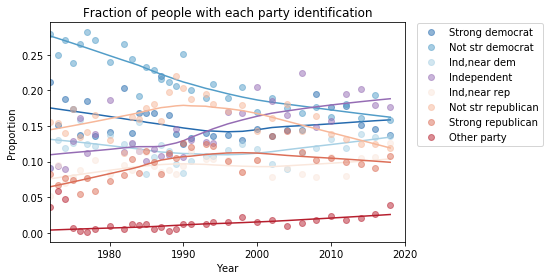

In [127]:
plot_columns_lowess(xtab_norm, columns, color_map)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with each party identification',
         xlim=[1972, 2020])

anchor_legend(1.02, 1.02)

This way of looking at the results suggests that changes in political alignment during this period have generally been slow and small.

The fraction of self-described moderates has not changed substantially.

The fraction of conservatives increased, but seems to be decreasing now; the number of liberals seems to be increasing.

The fraction of people at the extremes has increased, but it is hard to see clearly in this figure.

We can get a better view by plotting just the extremes.

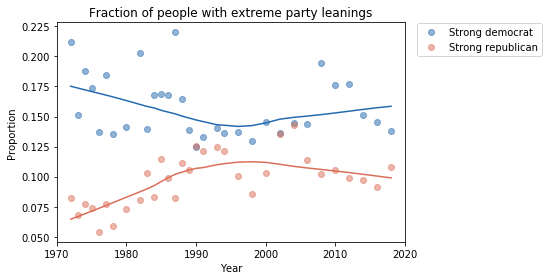

In [128]:
columns2 = ['Strong democrat', 'Strong republican']

plot_columns_lowess(xtab_norm, columns2, color_map)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Fraction of people with extreme party leanings',
         xlim=[1970, 2020])

anchor_legend(1.02, 1.02)

This figure shows that the fraction of people who describe themselves as "extreme" has increased from about 2.5% to about 4%.

In relative terms, that's a big increase.  But in absolute terms these tails of the distribution are still small.

**Exercise:** Let's do a similar analysis with `partyid`, which encodes responses to the question:

>Generally speaking, do you usually think of yourself as a Republican, Democrat, Independent, or what?

The valid responses are:

```
0	Strong democrat
1	Not str democrat
2	Ind,near dem
3	Independent
4	Ind,near rep
5	Not str republican
6	Strong republican
7	Other party
```

You can [read the codebook for `partyid` here](https://gssdataexplorer.norc.org/projects/52787/variables/141/vshow).

Here are the steps I suggest:

1) If you have not already saved this notebook, you should do that first.  If you are running on Colab, select "Save a copy in Drive" from the File menu.

2) Now, before you modify this notebook, make *another* copy and give it an appropriate name.

3) Search and replace `polviews` with `partyid` (use "Edit->Find and replace").

4) Run the notebook from the beginning and see what other changes you have to make.

You will have to make changes in `d7` and `columns`.  Otherwise you might get a message like 

`TypeError: '<' not supported between instances of 'float' and 'str'`

Also, you might have to drop "Other party" or change the color palette.

And you should change the titles of the figures.


What changes in party affiliation do you see over the last 50 years?  Are things going in the directions you expected?

Write a headline (or a couple) that describe the most substantial changes you see.

In [0]:
# Party affiliation seems pretty constant, with a drop of in the 90s and some 
# local resurgence. I suppose I'd expect stronger affiliation because of the 
# increase in polarization, but I suppose it makes sense that people are 
# more polarized with less conviction. 


In [0]:
#Headlines:
# As political polarization tends to the extremes, party affiliation stays fairly constant.
# Political polarization fails to inspire strong party alignment.